<a href="https://colab.research.google.com/github/JJooKim/detecting_defective_product/blob/main/defective_product_classification_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/Projects/defective_product_classification

/content/drive/MyDrive/Projects/defective_product_classification


## DataSet 불러오고 확인

In [3]:
import numpy as np
import pandas as pd
data_path = './'
train = pd.read_csv(data_path + 'train.csv', encoding='utf-8')

In [4]:
train.shape

(10000, 12)

In [5]:
train.info()
# wtcd NULL value 있돠

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   index    10000 non-null  int64  
 1   Num      10000 non-null  object 
 2   prod     10000 non-null  object 
 3   insp     10000 non-null  object 
 4   date     10000 non-null  object 
 5   buydate  10000 non-null  object 
 6   ingr_A   10000 non-null  float64
 7   ingr_B   10000 non-null  float64
 8   ingr_C   10000 non-null  float64
 9   wtcd     9989 non-null   object 
 10  gram     10000 non-null  float64
 11  label    10000 non-null  int64  
dtypes: float64(4), int64(2), object(6)
memory usage: 937.6+ KB


## EDA를 위한 전처리

In [6]:
train.head()

,index,Num,prod,insp,date,buydate,ingr_A,ingr_B,ingr_C,wtcd,gram,label
0,2,20230618산천074246A,GBMD,C,2023-06-18,2023-09-18,399.4063,6.4035,6.9409,F3,970.32,1
1,9,20230518창하053396B,GGMD,L,2023-05-18,2023-07-08,130.0951,5.8245,6.2857,F1,2490.08,0
2,10,20230505창하063135B,KCMD,C,2023-05-05,2023-07-02,131.5192,5.8040,6.0607,F3,487.37,0
3,12,20230505산천001612A,GBMD,K,2023-05-05,2023-06-04,128.5978,6.8720,6.1705,F3,707.94,1
4,16,20230409수성016088C,JJBB,K,2023-04-09,2023-04-14,320.6915,5.7474,6.3695,F3,1978.66,0


### index, Column Drop
* 아무 의미 없는 unique value이므로 Drop

In [7]:
train = train.drop(columns = ['index'])

### Num Column 범주형 변수로 전처리
* 제품번호 문자열의 가운데 깨진 글자들은 범주형으로 봐도 될 것 같음.

In [8]:
train['Num2'] = train['Num'].str[-1]
train['Num'] = train['Num'].str[8:-7]

Num_mapping = {
  '산천': 'Sanchun',
  '창하': 'Changha',
  '수성': 'Susung',
  '오포': 'Opo',
}


train['Num'] = train['Num'].map(Num_mapping)





### `date`, `buydate` Column 구성 요소별로 Column 나누기
* 연, 월, 일로 나누기

In [9]:
train['date_year'] = train['date'].apply(lambda x: x.split('-')[0])
train['date_month'] = train['date'].apply(lambda x: x.split('-')[1])
train['date_day'] = train['date'].apply(lambda x: x.split('-')[2])

In [10]:
train['buydate_year'] = train['buydate'].apply(lambda x: x.split('-')[0])
train['buydate_month'] = train['buydate'].apply(lambda x: x.split('-')[1])
train['buydate_day'] = train['buydate'].apply(lambda x: x.split('-')[2])

### `date`, `buydate`에 대한 요일 Column 만들기
* 연, 월, 일로 나누기

In [11]:
from datetime import datetime
import calendar

train['date_weekday'] = train['date'].apply(
    lambda dateString:
    calendar.day_name[datetime.strptime(dateString, "%Y-%m-%d").weekday()])

In [12]:
train['buydate_weekday'] = train['buydate'].apply(
    lambda dateString:
    calendar.day_name[datetime.strptime(dateString, "%Y-%m-%d").weekday()])

### 검수일자 구입일자 간의 날짜 차이를 나타내는 `days_between` column 생성
* 의미 있을 듯?

In [13]:
train['days_between'] = (pd.to_datetime(train['buydate']) - pd.to_datetime(train['date'])).dt.days

In [14]:
train

,Num,prod,insp,date,buydate,ingr_A,ingr_B,ingr_C,wtcd,gram,...,Num2,date_year,date_month,date_day,buydate_year,buydate_month,buydate_day,date_weekday,buydate_weekday,days_between
0,Sanchun,GBMD,C,2023-06-18,2023-09-18,399.4063,6.4035,6.9409,F3,970.32,...,A,2023,06,18,2023,09,18,Sunday,Monday,92
1,Changha,GGMD,L,2023-05-18,2023-07-08,130.0951,5.8245,6.2857,F1,2490.08,...,B,2023,05,18,2023,07,08,Thursday,Saturday,51
2,Changha,KCMD,C,2023-05-05,2023-07-02,131.5192,5.8040,6.0607,F3,487.37,...,B,2023,05,05,2023,07,02,Friday,Sunday,58
3,Sanchun,GBMD,K,2023-05-05,2023-06-04,128.5978,6.8720,6.1705,F3,707.94,...,A,2023,05,05,2023,06,04,Friday,Sunday,30
4,Susung,JJBB,K,2023-04-09,2023-04-14,320.6915,5.7474,6.3695,F3,1978.66,...,C,2023,04,09,2023,04,14,Sunday,Friday,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Sanchun,KCMD,C,2023-06-20,2023-07-08,405.6626,6.2900,6.8467,F3,777.82,...,A,2023,06,20,2023,07,08,Tuesday,Saturday,18
9996,Opo,GGMD,K,2023-05-15,2023-05-25,129.1664,6.0345,6.5257,F3,2548.73,...,A,2023,05,15,2023,05,25,Monday,Thursday,10
9997,Changha,GGMD,L,2023-06-14,2023-09-10,403.9895,6.2698,6.7227,F1,2769.71,...,B,2023,06,14,2023,09,10,Wednesday,Sunday,88
9998,Sanchun,JJBB,K,2023-04-05,2023-04-16,309.4751,5.7987,6.5499,F3,2005.46,...,A,2023,04,05,2023,04,16,Wednesday,Sunday,11


## EDA

In [15]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

### Class 분포 확인

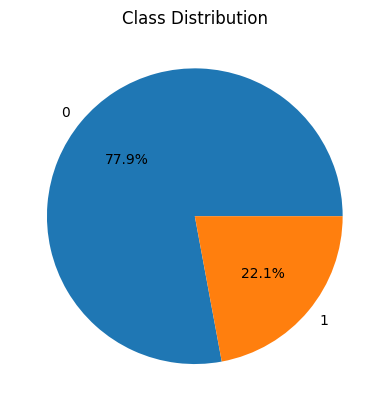

In [16]:
plt.pie(train["label"].value_counts(), labels=['0','1'], autopct='%1.1f%%')
plt.title('Class Distribution')
plt.show()

### Date 에 따른 label 분포

In [17]:
# 분포 비율을 표시하기위한 함수

def write_percent(ax):

  for idx, patch in enumerate(ax.patches):
    height = patch.get_height()
    width = patch.get_width()
    left_coord = patch.get_x()

    if idx < int(len(ax.patches) / 2):
      total_size = height + ax.patches[int(idx + len(ax.patches) / 2 )].get_height()
    else:
      total_size = height + ax.patches[int(idx - len(ax.patches) / 2 )].get_height()
    percent = height / total_size*100

    ax.text(x=left_coord + width/2.0,
            y=height + total_size*0.001,
            s=f'{percent:1.1f}%',
            ha='center', size=12)


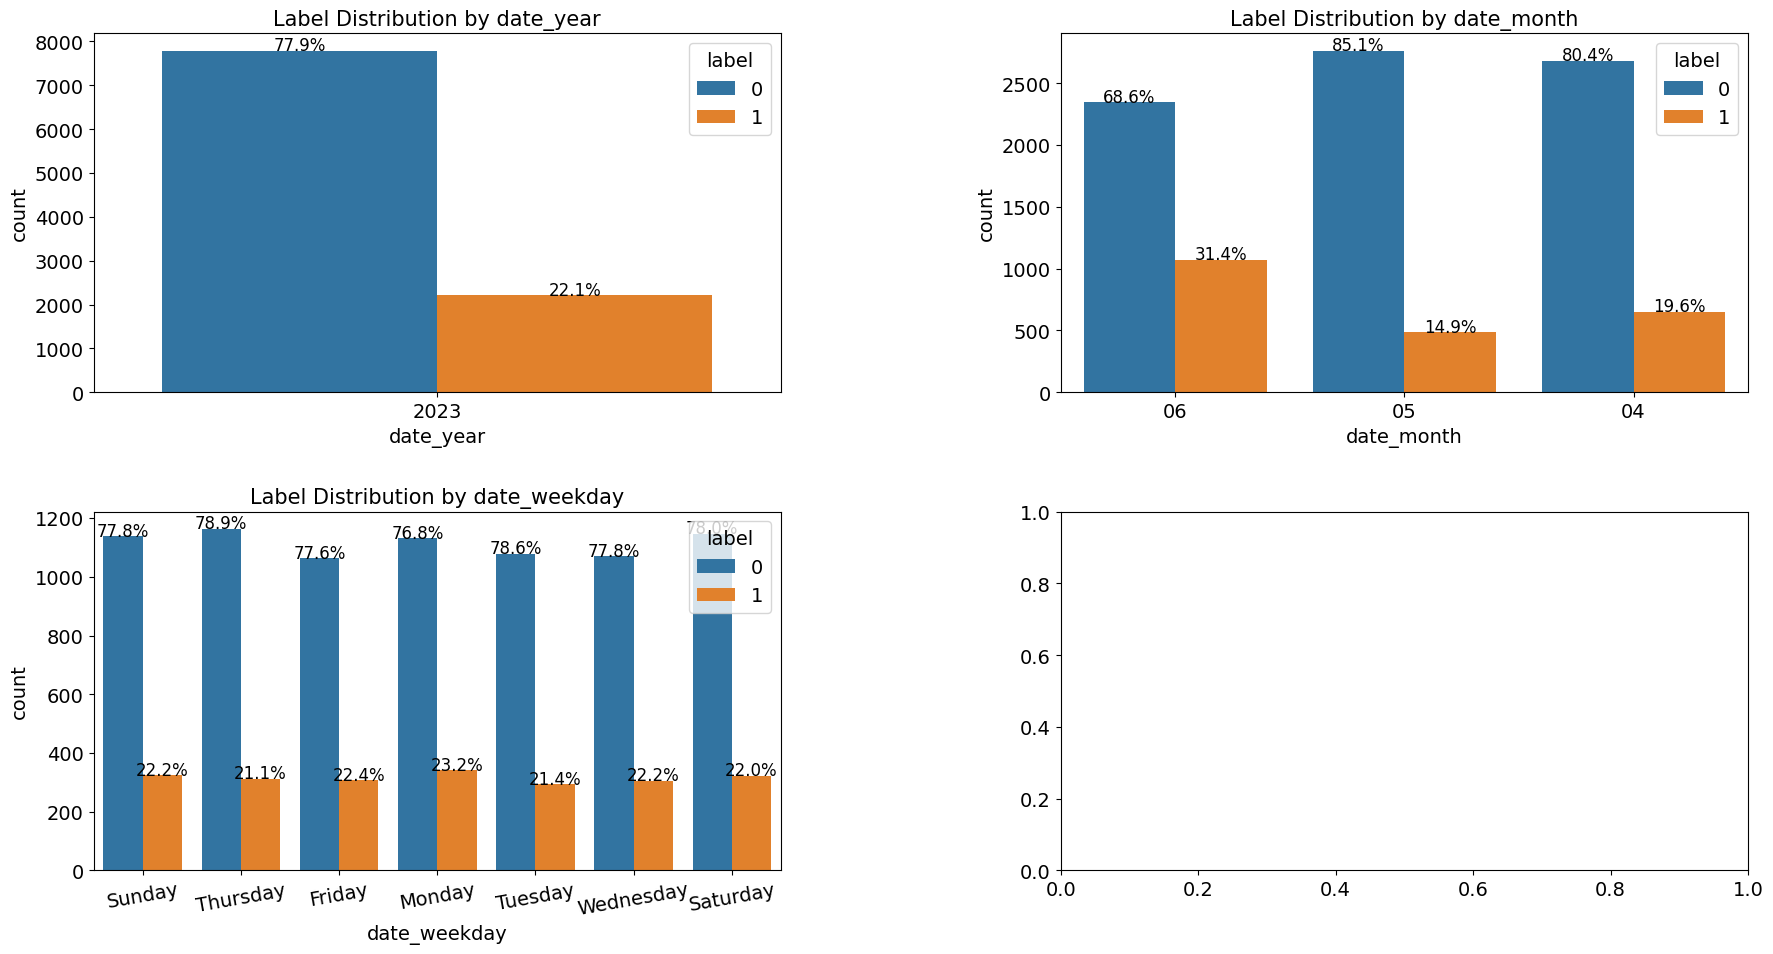

In [18]:
mpl.rc('font', size=14)
mpl.rc('axes', titlesize=15)
figure, axes = plt.subplots(nrows=2, ncols=2) # 2행 2열 Figure 생성
plt.tight_layout() # 그래프 사이에 여백 확보
figure.set_size_inches(20,10) # 전체 Figure 크기를 10 x 9인치로 설정

sns.countplot(x='date_year', data=train, hue='label', ax=axes[0,0])
sns.countplot(x='date_month', data=train, hue='label', ax=axes[0,1])
sns.countplot(x='date_weekday', data=train, hue='label', ax=axes[1,0])

axes[0, 0].set(title='Label Distribution by date_year')
axes[0, 1].set(title='Label Distribution by date_month')
axes[1, 0].set(title='Label Distribution by date_weekday')
axes[1, 0].tick_params(axis='x', labelrotation=10)

write_percent(axes[0,0])

write_percent(axes[0,1])

write_percent(axes[1,0])

### 월간 label 추이 based on Data Month

In [19]:
label_count = train.groupby(['date', 'label']).size().reset_index(name='count')
label_count_4 = label_count[label_count['date'].str[6]=='4']
label_count_5 = label_count[label_count['date'].str[6]=='5']
label_count_6 = label_count[label_count['date'].str[6]=='6']

[Text(0, 0, '01'),
 Text(1, 0, '02'),
 Text(2, 0, '03'),
 Text(3, 0, '04'),
 Text(4, 0, '05'),
 Text(5, 0, '06'),
 Text(6, 0, '07'),
 Text(7, 0, '08'),
 Text(8, 0, '09'),
 Text(9, 0, '10'),
 Text(10, 0, '11'),
 Text(11, 0, '12'),
 Text(12, 0, '13'),
 Text(13, 0, '14'),
 Text(14, 0, '15'),
 Text(15, 0, '16'),
 Text(16, 0, '17'),
 Text(17, 0, '18'),
 Text(18, 0, '19'),
 Text(19, 0, '20'),
 Text(20, 0, '21'),
 Text(21, 0, '22'),
 Text(22, 0, '23'),
 Text(23, 0, '24'),
 Text(24, 0, '25'),
 Text(25, 0, '26'),
 Text(26, 0, '27'),
 Text(27, 0, '28'),
 Text(28, 0, '29')]

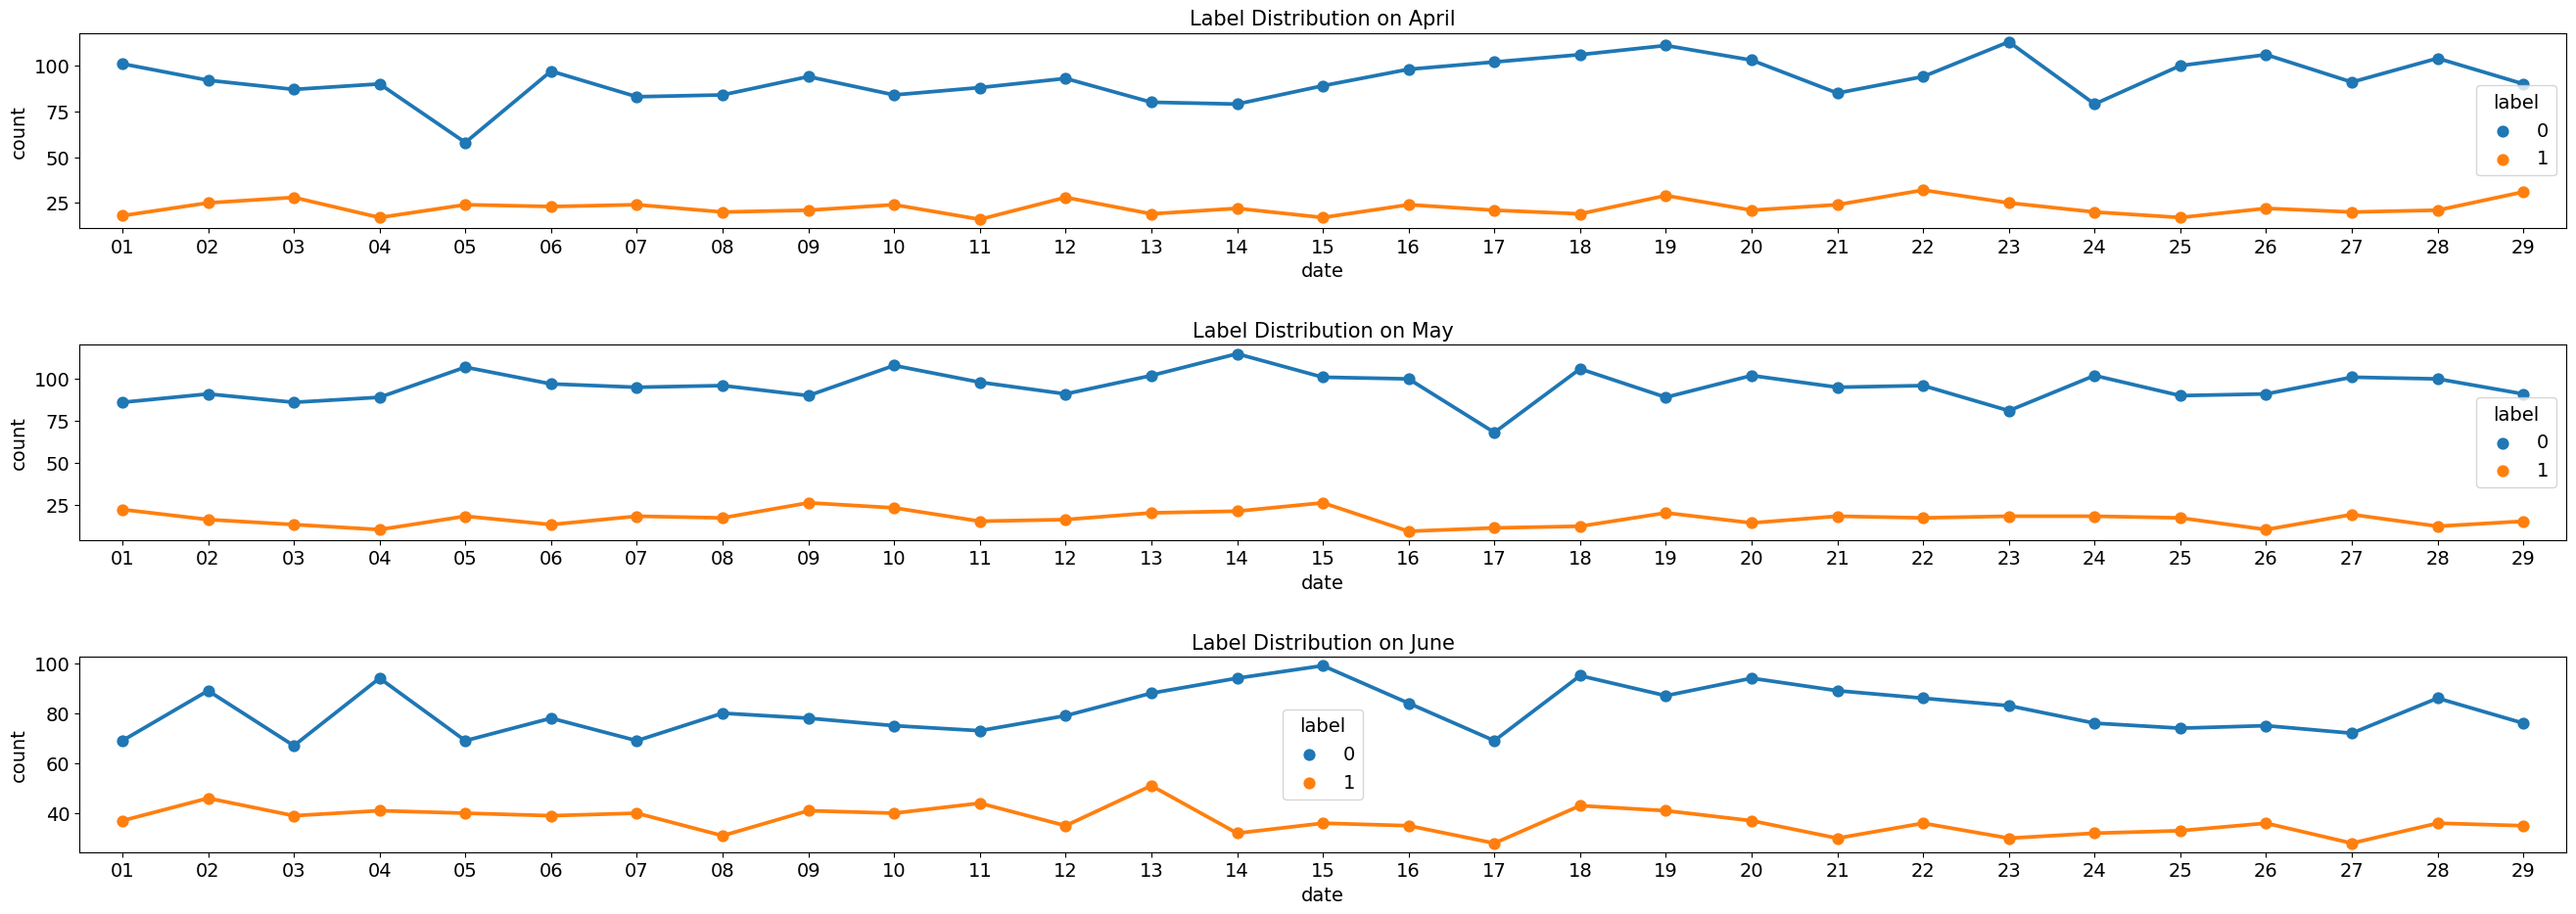

In [20]:
mpl.rc('font', size=14)
mpl.rc('axes', titlesize=15)
figure, axes = plt.subplots(nrows=3, ncols=1) # 2행 2열 Figure 생성
plt.tight_layout() # 그래프 사이에 여백 확보
figure.set_size_inches(30,10) # 전체 Figure 크기를 10 x 9인치로 설정

sns.pointplot(x='date', y='count', data=label_count_4, hue='label', ax=axes[0])
sns.pointplot(x='date', y='count', data=label_count_5, hue='label', ax=axes[1])
sns.pointplot(x='date', y='count', data=label_count_6, hue='label', ax=axes[2])


axes[0].set(title='Label Distribution on April')
axes[1].set(title='Label Distribution on May')
axes[2].set(title='Label Distribution on June')


axes[0].set_xticklabels(label_count_4['date'].str[-2:].unique())
axes[1].set_xticklabels(label_count_5['date'].str[-2:].unique())
axes[2].set_xticklabels(label_count_6['date'].str[-2:].unique())


### BuyDate에 따른 label 분포

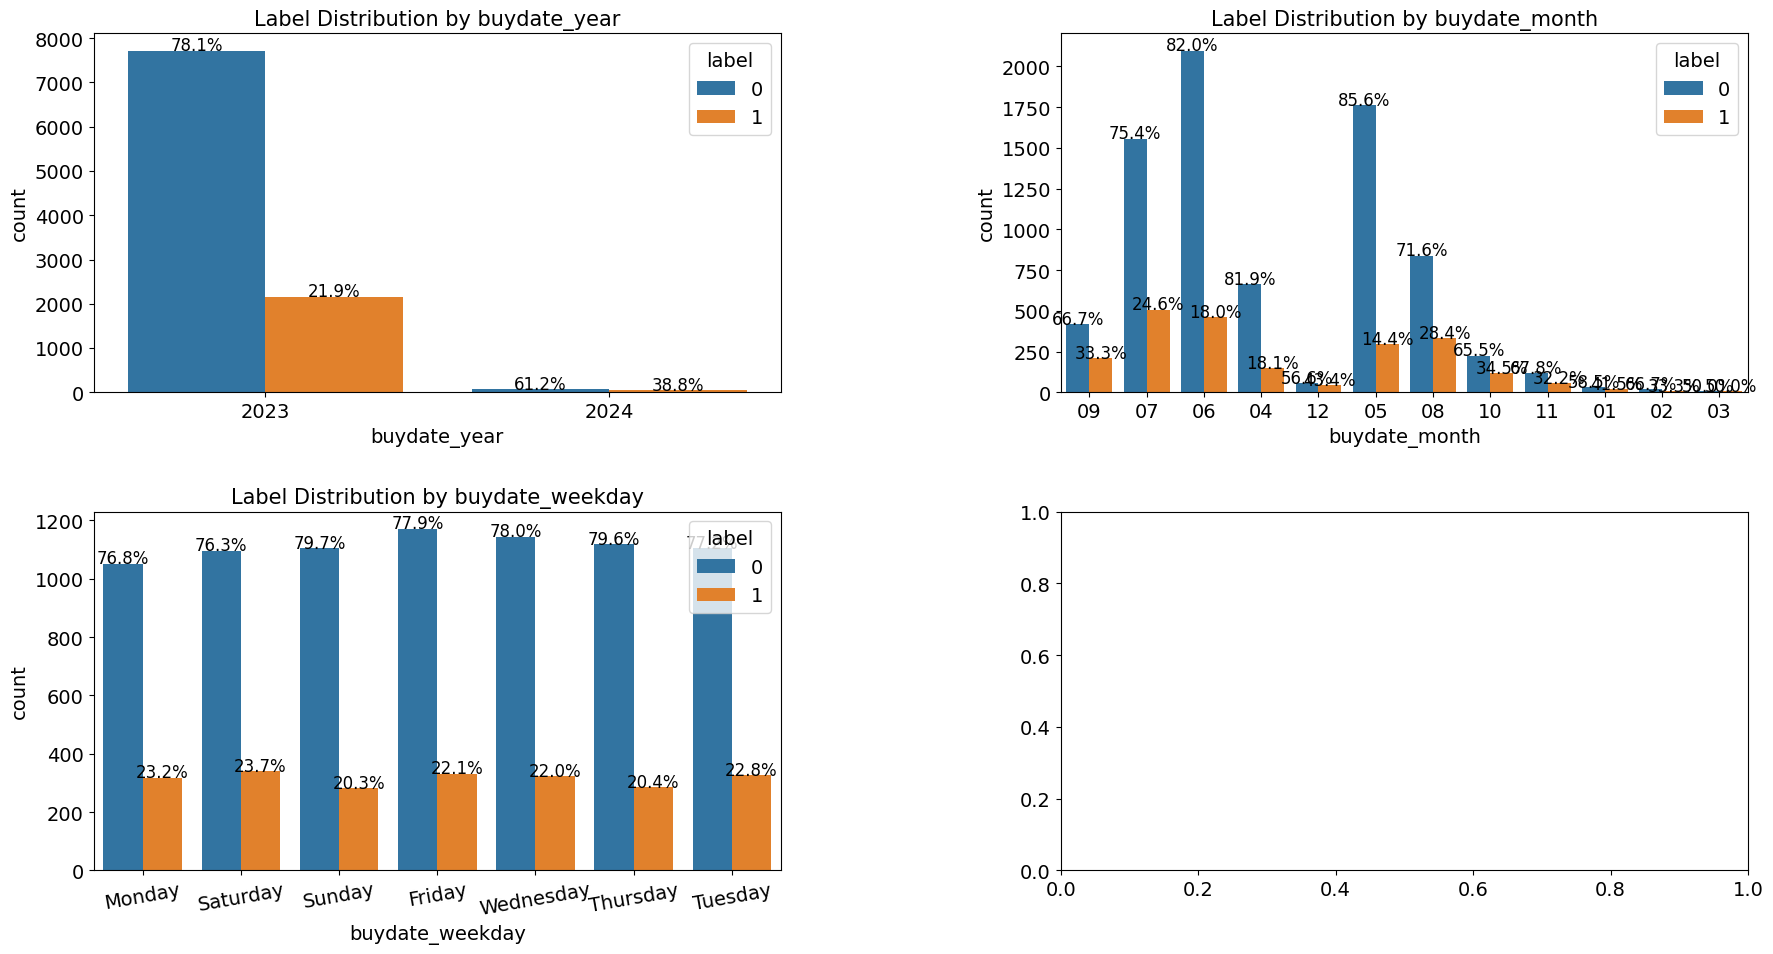

In [21]:
mpl.rc('font', size=14)
mpl.rc('axes', titlesize=15)
figure, axes = plt.subplots(nrows=2, ncols=2) # 2행 2열 Figure 생성
plt.tight_layout() # 그래프 사이에 여백 확보
figure.set_size_inches(20,10) # 전체 Figure 크기를 10 x 9인치로 설정

sns.countplot(x='buydate_year', data=train, hue='label', ax=axes[0,0])
sns.countplot(x='buydate_month', data=train, hue='label', ax=axes[0,1])
sns.countplot(x='buydate_weekday', data=train, hue='label', ax=axes[1,0])

axes[0, 0].set(title='Label Distribution by buydate_year')
axes[0, 1].set(title='Label Distribution by buydate_month')
axes[1, 0].set(title='Label Distribution by buydate_weekday')
axes[1, 0].tick_params(axis='x', labelrotation=10)

write_percent(axes[0,0])

write_percent(axes[0,1])

write_percent(axes[1,0])

### Num. prod, insp. wtcd 에 따른 label 분포

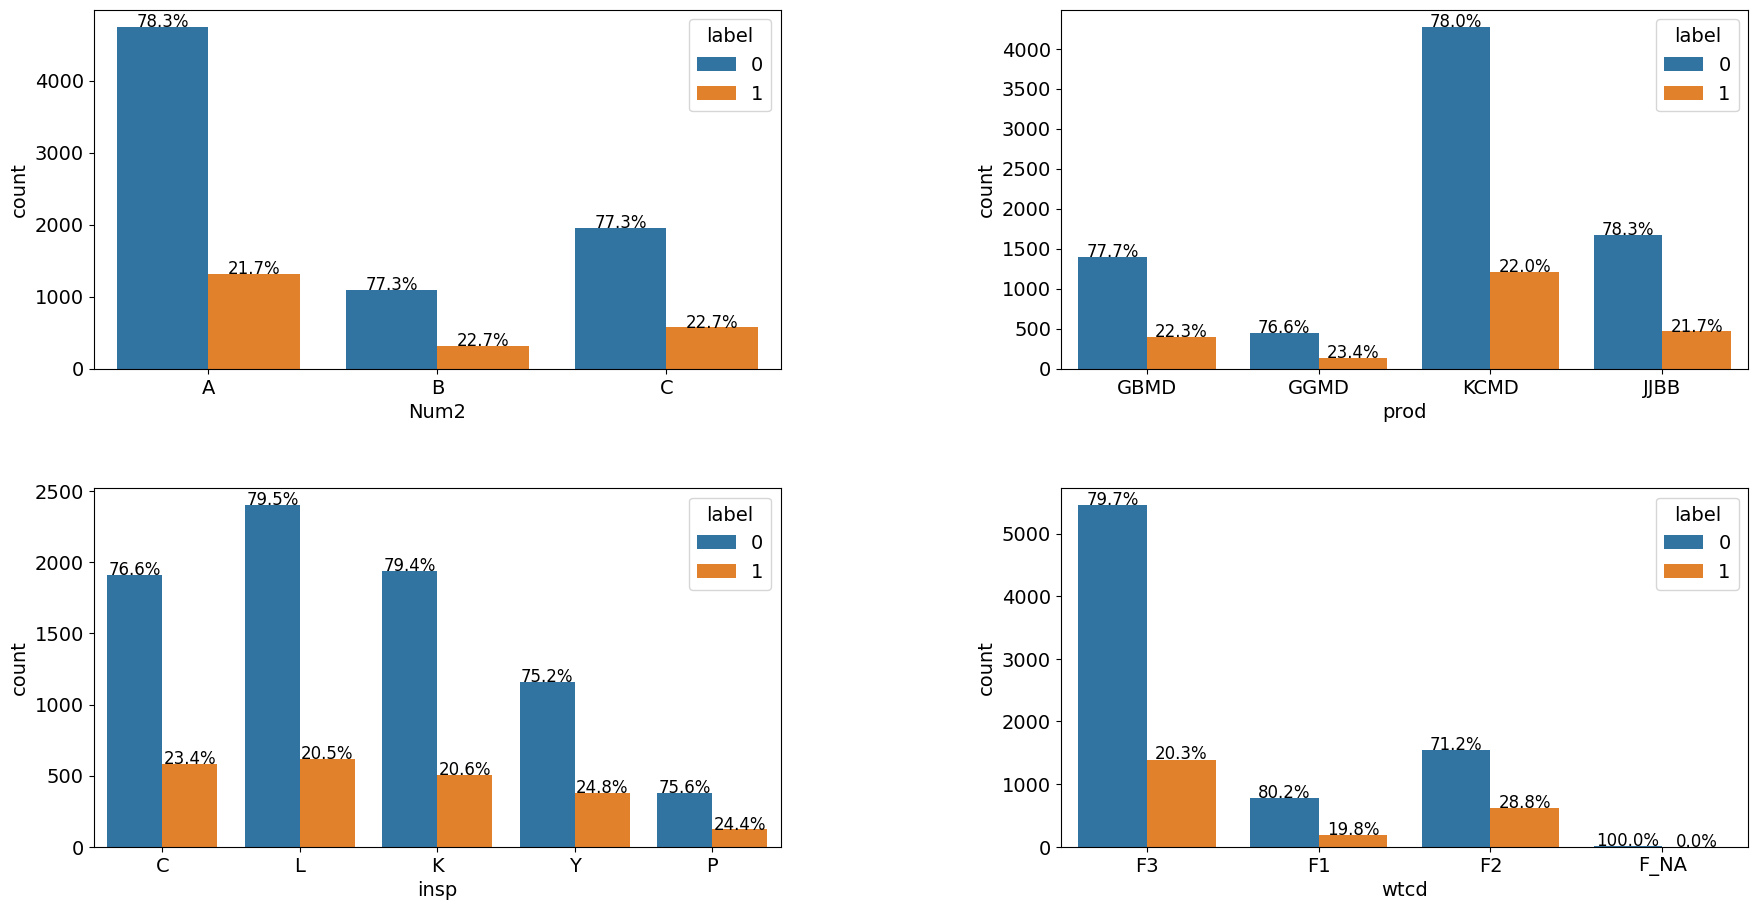

In [22]:
mpl.rc('font', size=14)
mpl.rc('axes', titlesize=15)
figure, axes = plt.subplots(nrows=2, ncols=2) # 2행 2열 Figure 생성
plt.tight_layout() # 그래프 사이에 여백 확보
figure.set_size_inches(20,10) # 전체 Figure 크기를 10 x 9인치로 설정

sns.countplot(x='Num2', data=train, hue='label', ax=axes[0,0])
sns.countplot(x='prod', data=train, hue='label', ax=axes[0,1])
sns.countplot(x='insp', data=train, hue='label', ax=axes[1,0])

train_fill_Na = train.copy()
train_fill_Na['wtcd'] = train['wtcd'].fillna('F_NA')
sns.countplot(x='wtcd', data=train_fill_Na, hue='label', ax=axes[1,1])

write_percent(axes[0,0])

write_percent(axes[0,1])

write_percent(axes[1,0])


write_percent(axes[1,1])

#### Checking Null Value in column `wtcd`

In [ ]:
train[train['wtcd'].isnull()]

,Num,prod,insp,date,buydate,ingr_A,ingr_B,ingr_C,wtcd,gram,...,Num2,date_year,date_month,date_day,buydate_year,buydate_month,buydate_day,date_weekday,buydate_weekday,days_between
152,오포,KCMD,K,2023-05-08,2023-05-12,128.3390,6.8925,6.2336,NaN,491.08,...,A,2023,05,08,2023,05,12,Monday,Friday,4
1500,오포,JJBB,K,2023-04-20,2023-06-17,319.0863,64811.0000,6.7270,NaN,1972.70,...,A,2023,04,20,2023,06,17,Thursday,Saturday,58
1867,산천,KCMD,C,2023-06-05,2023-06-20,401.9915,6.3852,6.9117,NaN,786.90,...,A,2023,06,05,2023,06,20,Monday,Tuesday,15
2965,오포,JJBB,C,2023-05-20,2023-06-17,131.5546,7.4636,6.1067,NaN,1782.97,...,A,2023,05,20,2023,06,17,Saturday,Saturday,28
3159,오포,KCMD,C,2023-06-10,2023-07-12,400.2173,6.0006,6.9271,NaN,769.65,...,A,2023,06,10,2023,07,12,Saturday,Wednesday,32
3503,오포,KCMD,K,2023-06-13,2023-06-26,396.8673,6.2746,6.9455,NaN,769.83,...,A,2023,06,13,2023,06,26,Tuesday,Monday,13
4750,오포,GBMD,L,2023-04-14,2023-10-12,321.9846,74528.0000,6.1506,NaN,897.94,...,A,2023,04,14,2023,10,12,Friday,Thursday,181
6213,창하,KCMD,K,2023-04-23,2023-07-07,318.4377,6.3588,6.4903,NaN,677.45,...,B,2023,04,23,2023,07,07,Sunday,Friday,75
8404,산천,KCMD,C,2023-04-27,2023-09-30,321.5667,6.6244,5.8504,NaN,700.87,...,A,2023,04,27,2023,09,30,Thursday,Saturday,156
8801,창하,JJBB,K,2023-04-13,2023-04-26,315.0384,5.8219,6.3853,NaN,1967.82,...,A,2023,04,13,2023,04,26,Thursday,Wednesday,13


### ingr_A, ingr_B, ingr_C, gram의 label에 따른 분포

<Axes: xlabel='label', ylabel='gram'>

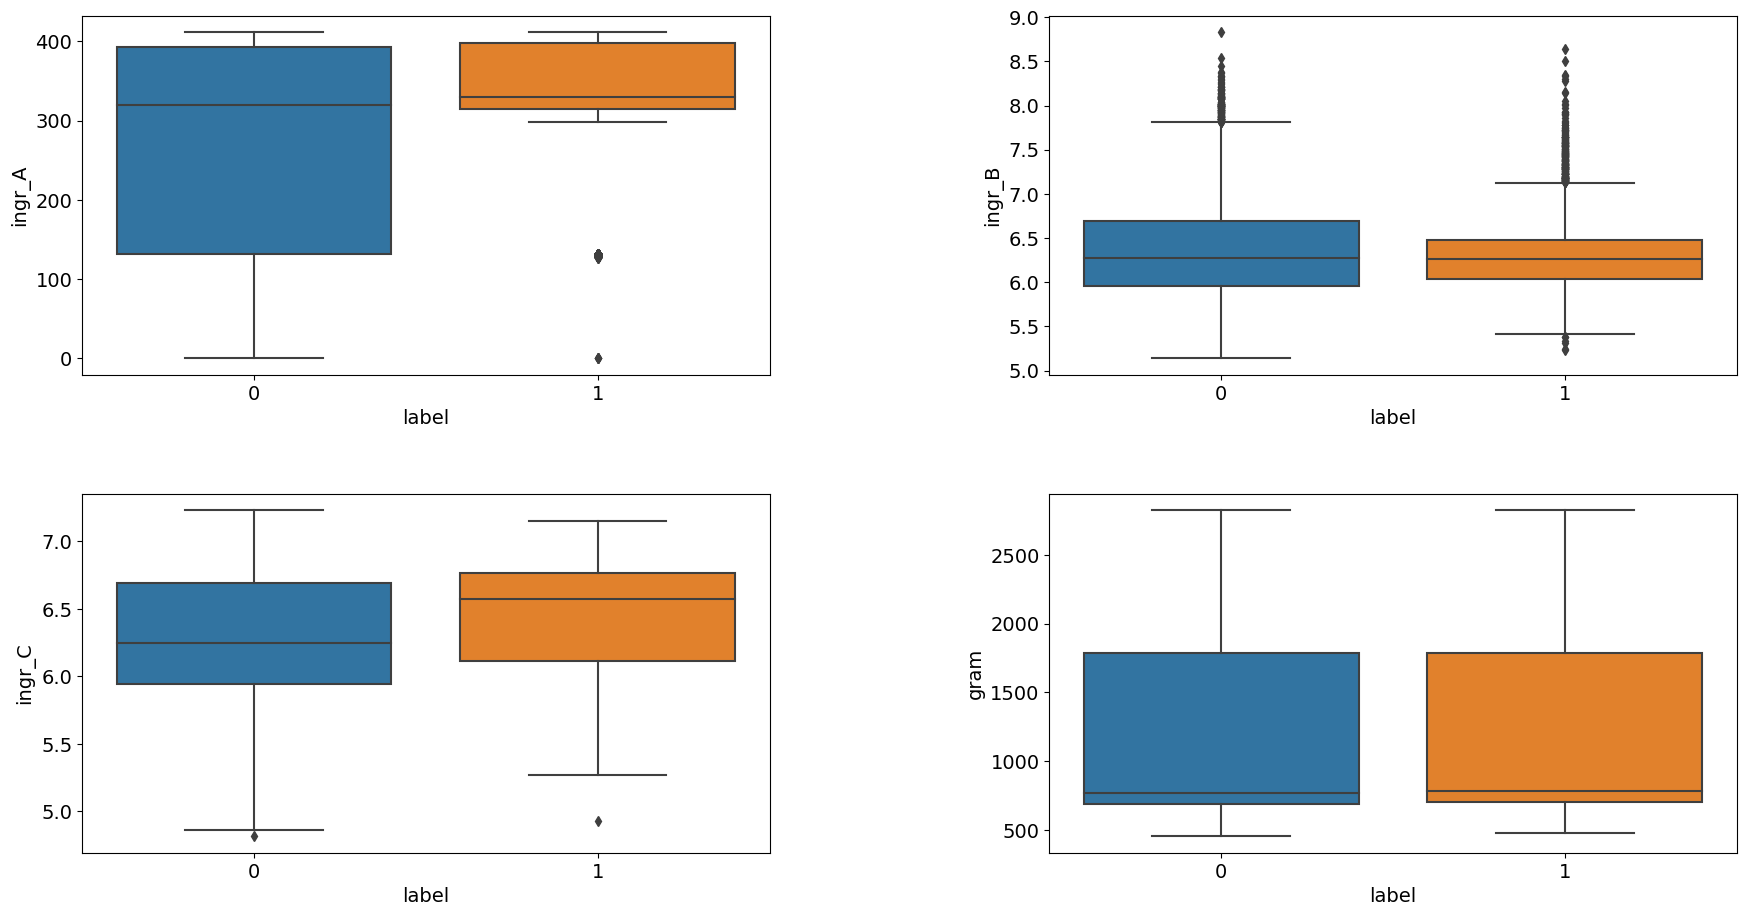

In [23]:
mpl.rc('font', size=14)
mpl.rc('axes', titlesize=15)
figure, axes = plt.subplots(nrows=2, ncols=2) # 2행 2열 Figure 생성
plt.tight_layout() # 그래프 사이에 여백 확보
figure.set_size_inches(20,10) # 전체 Figure 크기를 10 x 9인치로 설정

sns.boxplot(x='label', data=train, y='ingr_A', ax=axes[0,0])

ingr_B_outlier_delete_train = train.drop([1500,4750], axis=0, inplace=False)
sns.boxplot(x='label', data=ingr_B_outlier_delete_train, y='ingr_B', ax=axes[0,1])
sns.boxplot(x='label', data=train, y='ingr_C', ax=axes[1,0])
sns.boxplot(x='label', data=train, y='gram', ax=axes[1,1])



### 이상치 탐지

In [24]:
# 이상치 탐지 코드
def outlier_iqr(data, column):

    # lower, upper 글로벌 변수 선언하기
    global lower, upper

    # 4분위수 기준 지정하기
    q25, q75 = np.quantile(data[column], 0.25), np.quantile(data[column], 0.75)

    # IQR 계산하기
    iqr = q75 - q25

    # outlier cutoff 계산하기
    cut_off = iqr * 3.0

    # lower와 upper bound 값 구하기
    lower, upper = q25 - cut_off, q75 + cut_off

    print('IQR은',iqr, '이다.')
    print('lower bound 값은', lower, '이다.')
    print('upper bound 값은', upper, '이다.')

    # 1사 분위와 4사 분위에 속해있는 데이터 각각 저장하기
    upper_outlier = data[data[column] > upper]
    lower_outlier = data[data[column] < lower]

    return upper_outlier, lower_outlier

In [25]:
ingrB_upper_outlier, ingrB_lower_outlier = outlier_iqr(train, 'ingr_B')

IQR은 0.6488749999999994 이다.
lower bound 값은 4.025125000000002 이다.
upper bound 값은 8.567249999999998 이다.


In [26]:
ingrB_upper_outlier = train.iloc[[1500, 4750]]

In [27]:
ingrB_upper_outlier

,Num,prod,insp,date,buydate,ingr_A,ingr_B,ingr_C,wtcd,gram,...,Num2,date_year,date_month,date_day,buydate_year,buydate_month,buydate_day,date_weekday,buydate_weekday,days_between
1500,Opo,JJBB,K,2023-04-20,2023-06-17,319.0863,64811.0,6.7270,NaN,1972.70,...,A,2023,04,20,2023,06,17,Thursday,Saturday,58
4750,Opo,GBMD,L,2023-04-14,2023-10-12,321.9846,74528.0,6.1506,NaN,897.94,...,A,2023,04,14,2023,10,12,Friday,Thursday,181


### days_between의 라벨에 따른 분포

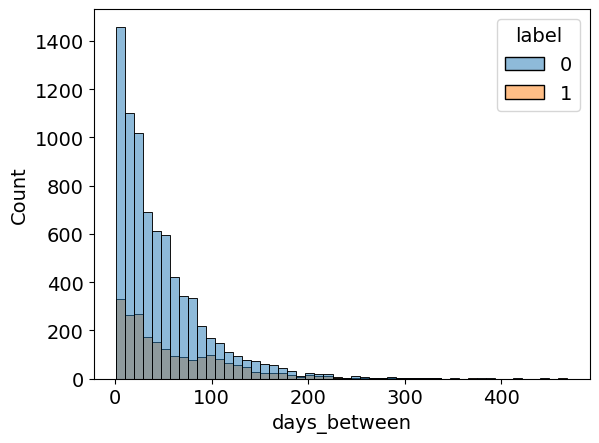

In [28]:
sns.histplot(data=train, x="days_between", hue='label', bins=50)
plt.show()

<Axes: xlabel='label', ylabel='days_between'>

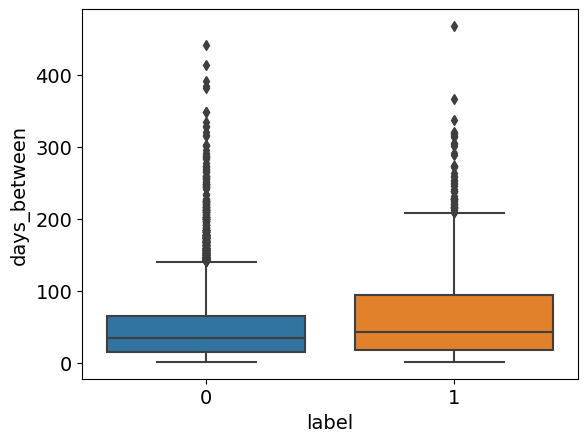

In [29]:
sns.boxplot(x='label', data=train, y='days_between')

## Training 을 위한 전처리

In [30]:
from sklearn.model_selection import train_test_split

X = train.drop(columns=['label'])
y = train['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [33]:
import random
# Get the unique values in the column
unique_values = X_train['wtcd'].unique()

# Calculate the percentages dynamically
probabilities = {value: (X_train['wtcd'] == value).sum() / len(X_train['wtcd']) for value in unique_values}
probabilities = {key: value / sum(probabilities.values()) for key, value in probabilities.items()}
def preprocessing(data):
  data = data.drop(columns = ['date', 'buydate', 'date_year', 'Num2'])

  data['wtcd'] = data.apply(lambda row: random.choices(list(probabilities.keys()), weights=list(probabilities.values()))[0] if pd.isnull(row['wtcd']) else row['wtcd'], axis=1)



  # List of columns to one-hot encode
  columns_to_encode = ['Num', 'prod', 'insp', 'wtcd' ]  # Add more columns if needed

  # Apply one-hot encoding to selected columns
  data = pd.get_dummies(data, columns=columns_to_encode)


  weekday_mapping = {
    'Sunday': 0,
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6
  }

  # Apply the mapping to the 'weekday' column
  data['date_weekday'] = data['date_weekday'].map(weekday_mapping)
  data['buydate_weekday'] = data['buydate_weekday'].map(weekday_mapping)

  data['date_day'] = data['date_day'].astype(int)
  data['date_month'] = data['date_month'].astype(int)
  data['buydate_year'] = data['buydate_year'].astype(int)
  data['date_weekday'] = data['date_weekday'].astype(int)
  data['buydate_month'] = data['buydate_month'].astype(int)
  data['buydate_day'] = data['buydate_day'].astype(int)

  return data



In [34]:
X_train = preprocessing(X_train)
X_train

,ingr_A,ingr_B,ingr_C,gram,date_month,date_day,buydate_year,buydate_month,buydate_day,date_weekday,...,prod_JJBB,prod_KCMD,insp_C,insp_K,insp_L,insp_P,insp_Y,wtcd_F1,wtcd_F2,wtcd_F3
9451,398.8158,6.0285,6.7493,2054.27,6,13,2023,7,4,2,...,1,0,0,0,1,0,0,0,0,1
3620,321.2676,6.8720,6.0769,706.91,4,19,2023,5,25,3,...,0,1,1,0,0,0,0,0,1,0
4753,398.1881,6.2552,6.8880,2050.62,6,25,2023,7,25,0,...,1,0,1,0,0,0,0,0,0,1
1584,398.9304,6.1919,7.1382,772.52,6,6,2023,10,22,2,...,0,1,0,0,0,1,0,0,0,1
3227,398.4670,6.4032,6.8862,969.71,6,8,2023,11,14,4,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6966,128.1367,5.8552,6.6565,524.59,5,14,2023,7,18,0,...,0,1,0,1,0,0,0,0,1,0
8596,394.8239,6.1864,7.0047,1065.16,6,28,2023,8,29,3,...,0,0,0,0,1,0,0,0,1,0
311,131.5103,5.8292,6.5372,494.20,5,3,2023,5,16,3,...,0,1,1,0,0,0,0,0,1,0
837,329.6519,6.7417,6.3682,718.83,4,1,2023,5,2,6,...,0,1,1,0,0,0,0,0,0,1


In [35]:
X_test = preprocessing(X_test)
X_test

,ingr_A,ingr_B,ingr_C,gram,date_month,date_day,buydate_year,buydate_month,buydate_day,date_weekday,...,prod_JJBB,prod_KCMD,insp_C,insp_K,insp_L,insp_P,insp_Y,wtcd_F1,wtcd_F2,wtcd_F3
3105,128.3235,7.1122,5.5272,493.30,5,22,2023,7,5,1,...,0,1,0,0,1,0,0,0,1,0
2039,323.7716,5.8709,5.8869,919.37,4,27,2023,7,22,4,...,0,0,1,0,0,0,0,0,0,1
2821,391.9743,6.2913,6.7901,787.66,6,29,2023,7,9,4,...,0,1,0,1,0,0,0,0,0,1
2512,322.3617,6.8105,6.4087,702.28,4,3,2023,5,8,1,...,0,1,1,0,0,0,0,0,0,1
6702,329.1775,6.3644,6.2719,688.54,4,16,2023,11,2,0,...,0,1,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,401.4523,6.4172,6.8426,2053.48,6,23,2023,7,6,5,...,1,0,1,0,0,0,0,0,1,0
1043,131.5577,6.1146,5.9810,487.75,5,27,2023,6,6,6,...,0,1,0,0,0,0,1,0,0,1
8039,322.2956,5.7783,6.0663,1976.55,4,21,2023,6,2,5,...,1,0,0,1,0,0,0,0,0,1
3351,323.8434,5.8156,5.7337,895.06,4,7,2023,9,29,5,...,0,0,0,0,1,0,0,1,0,0


## Baseline Models

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [38]:
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.651

In [39]:
from sklearn.ensemble import RandomForestClassifier

rf_clf_500 = RandomForestClassifier(n_estimators=500, random_state=123)
rf_clf_500.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, random_state=123)

In [40]:
y_pred = rf_clf_500.predict(X_test)
accuracy_score(y_test, y_pred)

0.7785

In [41]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(random_state=123 )
lr_clf.fit(X_train, y_train)
y_pred = lr_clf.predict(X_test)
accuracy_score(y_test, y_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.779

In [42]:
from xgboost import  XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [43]:
y_pred = xgb.predict(X_test)
accuracy_score(y_test, y_pred)

0.7575

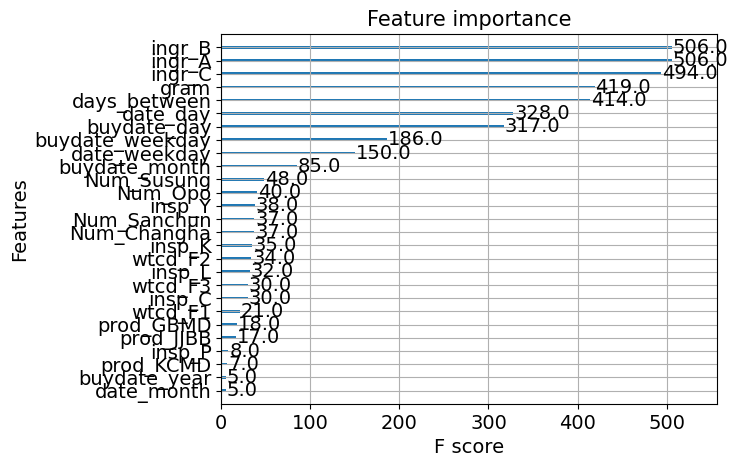

In [44]:
from xgboost import plot_importance
ax = plot_importance(xgb)